# Diplomado en Big Data - Introducción a las Herramientas de la Nube

### **Profesor:** Germán Leandro Contreras Sagredo
### **Ayudantes**
### Jorge Becerra de la Torre
### Valentina Rojas Mercier


# Actividad de la Clase 6: Visualización, _machine learning_

Este _colab_ está pensado para ser revisado y subido a una instancia de AWS SageMaker.

## Paso 1 - Obtención de variables de entorno.

In [ ]:
# Para que los gráficos se muestren en las casillas.
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [ ]:
from sagemaker import get_execution_role

# Obtenemos el ARN del rol IAM de la instancia
role = get_execution_role()

# Nombre del bucket donde almacenaremos los resultados.
bucket = 'clase-6'

## Paso 2 - Carga de datos

In [ ]:
# Importamos la librería a utilizar.
import pickle, gzip, numpy, boto3, json

# Descargamos los datos desde un bucket S3 preestablecido para carga de datasets.
s3 = boto3.client('s3')
s3.download_file(f'sagemaker-sample-files', 'datasets/image/MNIST/mnist.pkl.gz', 'mnist.pkl.gz')
# Descomprimimos los datos.
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [ ]:
# Verificamos que efectivamente se hayan cargado.
%ls

lost+found/  mnist.pkl.gz  Untitled.ipynb


## Paso 3 - Vista de los datos

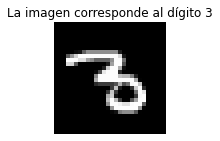

In [ ]:
import matplotlib.pyplot as plt

# Establecemos un alto y ancho fijo de los gráficos.
plt.rcParams['figure.figsize'] = (2, 10)

# Mostramos un dígito del dataset según la imagen.
def show_digit(img, caption='', subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption) # Le ponemos título a la imagen.

show_digit(train_set[0][30], f'La imagen corresponde al dígito {train_set[1][30]}')

## Paso 4 - Importamos el algoritmo KMeans de SageMaker y lo entrenamos

In [ ]:
# Importamos el algoritmo.
from sagemaker import KMeans

# Ubicación de los datos.
data_location = f's3://{bucket}/kmeans_ejemplo_input/data'
# Ubicación del output.
output_location = f's3://{bucket}/kmeans_ejemplo_output/output'

print(f'Los datos de entrenamiento se subirán a: {data_location}')
print(f'Los outputs de entrenamiento se subirán a: {output_location}')

kmeans = KMeans(
    role=role, # Entregamos el rol.
    instance_count=2, # Número de instancias EC2 a crear para correr.
    instance_type='ml.c4.xlarge', # Tipo de instancia EC2 a crear.
    output_path=output_location, # Ubicación de los archivos de entrenamiento.
    k=10, # Argumento K del algoritmo. Esto se traduce en el nº de clases (0-9).
    data_location=data_location, # Ubicación de los outputs del modelo.
)

Los datos de entrenamiento se subirán a: s3://clase-6/kmeans_ejemplo_input/data
Los outputs de entrenamiento se subirán a: s3://clase-6/kmeans_ejemplo_output/output


In [ ]:
%%time
kmeans.fit(kmeans.record_set(train_set[0])) # Entrenamos con el set de entrenamiento.

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-09-01 22:02:39 Starting - Starting the training job...
2021-09-01 22:02:53 Starting - Launching requested ML instancesProfilerReport-1630533759: InProgress
......
2021-09-01 22:04:09 Starting - Preparing the instances for training...............
2021-09-01 22:06:36 Downloading - Downloading input data.........
2021-09-01 22:08:08 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/01/2021 22:08:12 INFO 139777173661504] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_lif

## Paso 5 - Deploy del modelo en un _endpoint_

In [ ]:
%%time
# Además de crear el endpoint, retorna el predictor para probar.
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 249 ms, sys: 10.1 ms, total: 259 ms
Wall time: 7min 32s


## Paso 6 - Validación del modelo a partir de la predicción de un _batch_




Cluster 0:


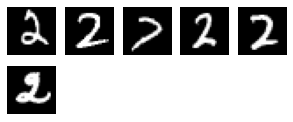




Cluster 1:


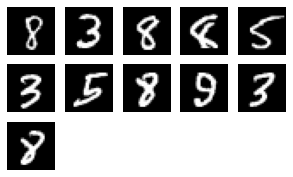




Cluster 2:


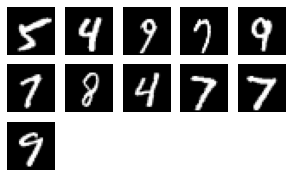




Cluster 3:


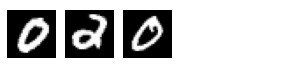




Cluster 4:


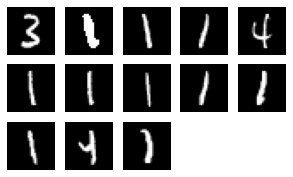




Cluster 5:


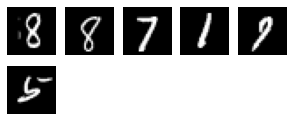




Cluster 6:


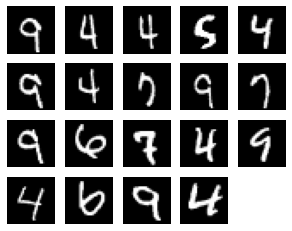




Cluster 7:


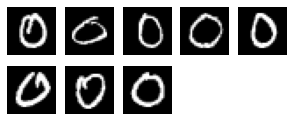




Cluster 8:


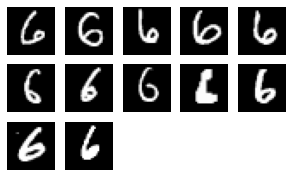




Cluster 9:


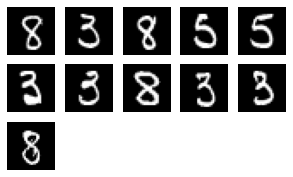

CPU times: user 4.4 s, sys: 35.5 ms, total: 4.43 s
Wall time: 4.67 s


In [ ]:
%%time

# Hacemos la predicción de los 100 primeros elementos del set de validación.
result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

# Graficamos los clusters.
for cluster in range(10):
    print(f'\n\n\nCluster {int(cluster)}:')
    digits = [img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster]
    height = ((len(digits) - 1) // 5) + 1
    width = 5
    plt.rcParams['figure.figsize'] = (width, height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits) :]:
        subplot.axis('off')
    plt.show()

## Paso 7 - Eliminamos el _endpoint_ para no tener instancias corriendo.

In [ ]:
kmeans_predictor.delete_endpoint()

## Nota

Si quisiéramos reutilizar un _endpoint_ ya creado, podemos definir un objeto de clase Predictor que reciba el nombre del _endpoint_. Más información: https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html